In [2]:
import pandas as pd
import numpy as np
from eodhd import APIClient
import sys
sys.path.insert(0, "/Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src")
from Features import fundamental_features_new, fundamental_features, technical_features
import talib
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sklearn
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna
from optuna import Trial
import shap


## Data Extraction

In [3]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])
zacks_fc['filing_date'] = zacks_fc['filing_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

data = {
    "zacks_fc": zacks_fc,
    "zacks_fr": zacks_fr
}

C:\Users\manis\AppData\Local\Temp\ipykernel_26280\3539703636.py:1: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
C:\Users\manis\AppData\Local\Temp\ipykernel_26280\3539703636.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')


In [4]:
obj = fundamental_features_new.BuildFeatures(data, 'AAPL')
obj.process_financial_statements()
obj.extend_monthly()
tech = technical_features.BuildFeatures('AAPL')
tech.build_technical_features()
tech.technical_features.index = tech.technical_features.index.tz_convert('US/Eastern')
obj.features = pd.merge_asof(obj.fundamental_features, tech.technical_features, left_index=True, right_index=True, direction='backward')

obj.stock.sort_index(inplace=True)
obj.features = pd.merge_asof(obj.features, obj.stock[['Close']],left_index=True, right_index=True, direction='backward')

obj.features.rename(columns={'Close': 'Close_Price'}, inplace=True)

c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users\manis\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `i

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

In [5]:
obj.features.head()

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.95036602,6395,2.11828876,6404,58.72284150,2.03872932,2.04707809,0.06319640,2.11828876,2.11828876
2006-05-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.79869437,6426,2.05087900,6413,60.46857190,1.87294297,1.89749794,0.09329067,1.79869437,1.79869533
2006-06-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.68584359,6446,1.79297626,6442,54.01379192,1.74043283,1.69808216,0.07433079,1.72346032,1.72346056
2006-07-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.52484286,6457,2.04516029,6468,52.27348185,1.94148095,1.86498206,0.09148317,2.04516029,2.04516172
2006-08-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.92418480,6478,2.06893468,6487,59.63377607,2.03045125,2.07871228,0.04935403,2.04185057,2.04185081


In [6]:
start_date = '2006-01-01'
end_date = '2025-01-01'

In [7]:
print(tech.technical_features.shape)
print(obj.fundamental_features.shape)

(11156, 125)
(223, 45)


In [8]:
obj.features['Dividend Payout Ratio'].isna().sum()

223

All rows in divident payout ratio are NaN values - need to check

In [9]:
final_df = obj.features.copy()
final_df = final_df.sort_index()
final_df

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.95036602,6395,2.11828876,6404,58.72284150,2.03872932,2.04707809,0.06319640,2.11828876,2.11828876
2006-05-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.79869437,6426,2.05087900,6413,60.46857190,1.87294297,1.89749794,0.09329067,1.79869437,1.79869533
2006-06-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.68584359,6446,1.79297626,6442,54.01379192,1.74043283,1.69808216,0.07433079,1.72346032,1.72346056
2006-07-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.52484286,6457,2.04516029,6468,52.27348185,1.94148095,1.86498206,0.09148317,2.04516029,2.04516172
2006-08-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.92418480,6478,2.06893468,6487,59.63377607,2.03045125,2.07871228,0.04935403,2.04185057,2.04185081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 20:00:00-04:00,90753.00000000,30736.00000000,1.53000000,NaN,128416.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,192.47309875,10963,215.94422913,10968,5993.53623962,211.17402526,215.54830302,5.75067672,209.91448975,209.91448975
2024-07-31 20:00:00-04:00,85777.00000000,28202.00000000,1.40000000,NaN,125435.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,216.76148987,10994,234.03344727,10987,6605.60905457,217.57200402,224.45998512,5.00317423,221.33610535,221.33610535
2024-08-31 20:00:00-04:00,85777.00000000,28202.00000000,1.40000000,NaN,125435.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,220.78408813,11007,229.28536987,11019,6619.78598022,227.92413432,226.44932623,2.91358566,228.49710083,228.49710083


## Applying Regressor

In [10]:
nan_counts = final_df.isnull().sum()
print(nan_counts[nan_counts > 1])
len(nan_counts[nan_counts > 1])

Dividend Payout Ratio         223
                              223
per_code                      223
non_perform_asset_tot_loan    223
loan_loss_reserve             223
lterm_debt_cap                 86
tot_debt_tot_equity            86
ebitda_margin                 223
loss_ratio                    223
exp_ratio                     223
comb_ratio                    223
dtype: int64


11

In [11]:
drop_cols = final_df.columns[nan_counts > 1]
final_df = final_df.drop(drop_cols, axis=1)
final_df.shape

(223, 160)

In [12]:
matching = [col for col in final_df.columns if 'return' in col.lower() or 'price' in col.lower()]
matching

['Absolute_Price_Oscillator',
 'Average_Price',
 'Typical_Price',
 'Weighted_Close_Price',
 'Percentage_Price_Oscillator',
 'Median_Price',
 'Midpoint_Price_over_period',
 'Close_Price',
 'Close_Price']

In [13]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

final_df['next_return'] = final_df['Close_Price'].shift(-1) / final_df['Close_Price'] - 1
final_df['next_return_median'] = final_df['Median_Price'].shift(-1) / final_df['Median_Price'] - 1
print(final_df.shape)


(223, 161)


In [14]:
final_df.head()

,total revenue,ebitda,eps,total_current_assets,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,...,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,next_return,next_return_median
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6395,2.11828876,6404,58.72284150,2.03872932,2.04707809,0.06319640,2.11828876,-0.15087385,-0.14249143
2006-05-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6426,2.05087900,6413,60.46857190,1.87294297,1.89749794,0.09329067,1.79869437,-0.04182704,-0.05170966
2006-06-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6446,1.79297626,6442,54.01379192,1.74043283,1.69808216,0.07433079,1.72346032,0.18665935,0.18083091
2006-07-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6457,2.04516029,6468,52.27348185,1.94148095,1.86498206,0.09148317,2.04516029,-0.00161832,0.00037119
2006-08-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6478,2.06893468,6487,59.63377607,2.03045125,2.07871228,0.04935403,2.04185057,0.13456129,0.14256007


In [15]:
train_df = final_df['2006-04-30':'2019-01-01'].copy()
valid_df = final_df['2019-01-01': '2022-01-01'].copy()
test_df = final_df['2022-01-01':].copy()

In [16]:
x_train = train_df.drop(['next_return', 'next_return_median'], axis=1)
y_train = train_df['next_return']
y_train_median = train_df['next_return_median']

x_valid = valid_df.drop(['next_return', 'next_return_median'], axis=1)
y_valid = valid_df['next_return']
y_valid_median = valid_df['next_return_median']

x_test = test_df.drop(['next_return', 'next_return_median'], axis=1)
y_test = test_df['next_return']
y_test_median = test_df['next_return_median']

In [17]:
# 1. Identify numeric and non-numeric columns in x_train
numeric_cols = x_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
non_numeric_cols = x_train.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).columns

# 2. Initialize the scaler and scale the numeric columns
scaler = StandardScaler()
x_train_numeric_scaled = scaler.fit_transform(x_train[numeric_cols])
x_valid_numeric_scaled = scaler.transform(x_valid[numeric_cols])
x_test_numeric_scaled = scaler.transform(x_test[numeric_cols])

# 3. Convert the scaled numeric arrays back to DataFrames
x_train_numeric_scaled_df = pd.DataFrame(x_train_numeric_scaled, columns=numeric_cols, index=x_train.index)
x_valid_numeric_scaled_df = pd.DataFrame(x_valid_numeric_scaled, columns=numeric_cols, index=x_valid.index)
x_test_numeric_scaled_df = pd.DataFrame(x_test_numeric_scaled, columns=numeric_cols, index=x_test.index)

# 4. Combine scaled numeric columns with the unscaled non-numeric columns
#x_train_final = pd.concat([x_train_numeric_scaled_df, x_train[non_numeric_cols]], axis=1)
#x_valid_final = pd.concat([x_valid_numeric_scaled_df, x_valid[non_numeric_cols]], axis=1)
#x_test_final = pd.concat([x_test_numeric_scaled_df, x_test[non_numeric_cols]], axis=1)

# Optionally, reorder columns to match the original order in x_train
#x_train_final = x_train_final[x_train.columns]
#x_valid_final = x_valid_final[x_valid.columns]
#x_test_final = x_test_final[x_test.columns]

# Now x_train_final, x_valid_final, and x_test_final have the numeric features scaled and the string features intact.
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
print("Validation MSE:", mse_valid)

Validation MSE: 0.013078752608412354


In [18]:
# using median price
rf_med = RandomForestRegressor(random_state=2)
rf_med.fit(x_train_numeric_scaled_df, y_train_median)

# Optionally, predict and evaluate on the validation set
y_valid_pred_med = rf_med.predict(x_valid_numeric_scaled_df)
mse_valid_med = mean_squared_error(y_valid_median, y_valid_pred_med)
print("Validation MSE:", mse_valid_med)

Validation MSE: 0.012526632592447193


In [19]:
# Using the model's built-in score method
r2_builtin = rf.score(x_valid_numeric_scaled_df, y_valid)
print("R^2 score (built-in):", r2_builtin)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred)
print("R^2 score:", r2)

R^2 score (built-in): -0.8556000154481866
R^2 score: -0.8556000154481866


In [20]:
# Using median price
r2_builtin_med = rf_med.score(x_valid_numeric_scaled_df, y_valid_median)
print("R^2 score (built-in):", r2_builtin_med)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred_med = rf_med.predict(x_valid_numeric_scaled_df)
r2_med = r2_score(y_valid_median, y_valid_pred_med)
print("R^2 score:", r2_med)

R^2 score (built-in): -0.7452795636987073
R^2 score: -0.7452795636987073


In [21]:
x_train[non_numeric_cols].head()

,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_type
filing_date,,,,,,,
2006-04-30 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-05-31 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-06-30 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-07-31 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-08-31 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q


## Optuna Implementation

In [22]:
def objective(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=5)
    rf_max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    rf_max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=1
    )
    
    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)
    
    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, train=x_train_numeric_scaled_df, labels=y_train, val=x_valid_numeric_scaled_df, val_labels=y_valid), n_trials=400)

[I 2025-03-18 20:15:43,238] A new study created in memory with name: no-name-333cba49-5ab1-4176-9d52-2d3d1ffce8d8
[I 2025-03-18 20:15:43,287] Trial 0 finished with value: -0.9462597756912579 and parameters: {'n_estimators': 45, 'max_features': 'log2', 'min_samples_leaf': 1, 'max_depth': 4}. Best is trial 0 with value: -0.9462597756912579.
[I 2025-03-18 20:15:43,375] Trial 1 finished with value: -0.748083583094294 and parameters: {'n_estimators': 95, 'max_features': 'log2', 'min_samples_leaf': 2, 'max_depth': 5}. Best is trial 1 with value: -0.748083583094294.
[I 2025-03-18 20:15:43,421] Trial 2 finished with value: -1.289283622763405 and parameters: {'n_estimators': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'max_depth': 5}. Best is trial 1 with value: -0.748083583094294.
[I 2025-03-18 20:15:43,463] Trial 3 finished with value: -1.274758016575043 and parameters: {'n_estimators': 35, 'max_features': 'log2', 'min_samples_leaf': 1, 'max_depth': 10}. Best is trial 1 with value: -0.

In [24]:
study.best_params

{'n_estimators': 65,
 'max_features': 'log2',
 'min_samples_leaf': 6,
 'max_depth': 2}

In [25]:
rf = RandomForestRegressor(**study.best_params)

In [26]:
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
mse_valid_op = mean_squared_error(y_valid, y_valid_pred_op)
print("Validation MSE:", mse_valid_op)

Validation MSE: 0.0084960597878301


In [27]:
# predict and then compute R2 with r2_score:
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred_op)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_op) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: -0.20541225494286763
SS total: 0.2537373841253839
SS residual: 0.3058581523618836


## Feature Importance

                                       Feature  Importance
116                            MACD_EXT_Signal  0.04340344
113                                MACD_Signal  0.04254367
13                        pretax_profit_margin  0.03641072
109                         Standard_Deviation  0.03244010
96   Hilbert_Transform_Instantaneous_Trendline  0.02961863
..                                         ...         ...
64                            Long_Line_Candle  0.00000000
63                            Long_Legged_Doji  0.00000000
62                               Ladder_Bottom  0.00000000
61                           Kicking_by_Length  0.00000000
151                                Close_Price  0.00000000

[152 rows x 2 columns]


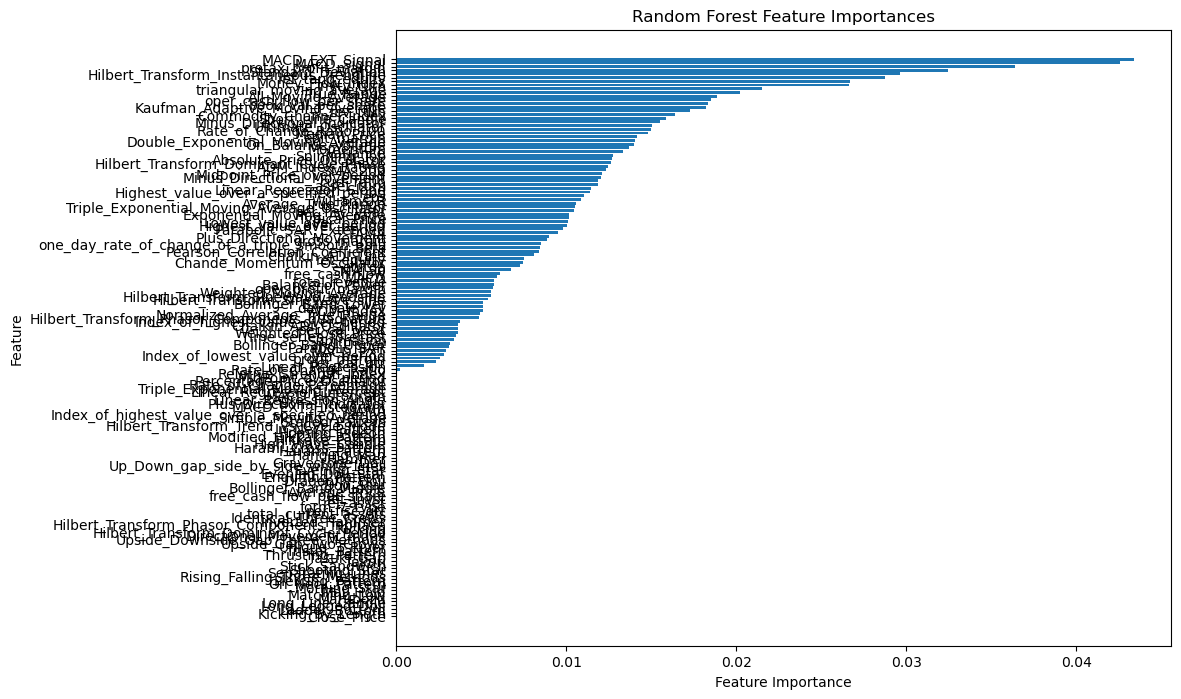

In [28]:
# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df = pd.DataFrame({
    'Feature': x_train_numeric_scaled_df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [29]:
features = feature_importance_df[feature_importance_df['Importance'] > 0.01]
features.shape

(46, 2)

In [30]:
features

,Feature,Importance
116,MACD_EXT_Signal,0.04340344
113,MACD_Signal,0.04254367
13,pretax_profit_margin,0.03641072
109,Standard_Deviation,0.03244010
96,Hilbert_Transform_Instantaneous_Trendline,0.02961863
21,ret_tang_equity,0.02875337
140,Money_Flow_Index,0.02669370
17,invty_turn,0.02665554
122,triangular_moving_average,0.02152622
150,True_Range,0.02023146


In [31]:
x_train_red = x_train_numeric_scaled_df[features['Feature']]
x_valid_red = x_valid_numeric_scaled_df[features['Feature']]
x_test_red = x_test_numeric_scaled_df[features['Feature']]
x_train_red.shape

(153, 46)

In [32]:
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_red, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red = rf.predict(x_valid_red)
mse_valid_red = mean_squared_error(y_valid, y_valid_pred_red)
print("Validation MSE:", mse_valid_red)

Validation MSE: 0.013314682676439189


In [46]:
# predict and then compute R2 with r2_score:
y_valid_pred_red = rf.predict(x_valid_red)
r2 = r2_score(y_valid, y_valid_pred_red)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_red) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: -0.8890735316911418
SS total: 0.2537373841253839
SS residual: 0.4793285763518108


In [49]:
# Combine validation and test sets
x_out_of_sample = pd.concat([x_valid_red, x_test_red], axis=0)
y_out_of_sample = pd.concat([y_valid, y_test], axis=0)

print("Out-of-sample feature set shape:", x_out_of_sample.shape)
print("Out-of-sample return series shape:", y_out_of_sample.shape)

Out-of-sample feature set shape: (70, 46)
Out-of-sample return series shape: (70,)


In [50]:
# Use the trained random forest model (with or without hyperparameter tuning)
y_out_of_sample_pred = rf.predict(x_out_of_sample)

# Create a DataFrame to hold actual and predicted returns
strategy_df = pd.DataFrame(index=y_out_of_sample.index)
strategy_df['actual_return'] = y_out_of_sample
strategy_df['predicted_return'] = y_out_of_sample_pred

In [51]:
# Compute the sign of the predicted return
strategy_df['position'] = np.where(strategy_df['predicted_return'] > 0, 1, -1)

# Strategy return on each day = (position) * (actual return of that day)
strategy_df['strategy_return'] = strategy_df['position'] * strategy_df['actual_return']

In [52]:
strategy_df['cumulative_strategy'] = (1 + strategy_df['strategy_return']).cumprod() - 1

# For a simple buy-and-hold in AAPL (always long):
strategy_df['cumulative_buy_and_hold'] = (1 + strategy_df['actual_return']).cumprod() - 1

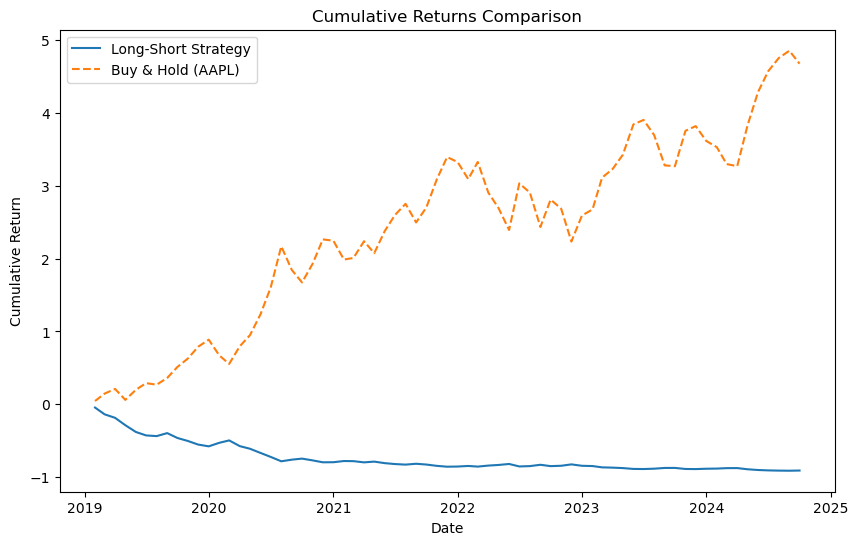

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(strategy_df.index, strategy_df['cumulative_strategy'], label='Long-Short Strategy')
plt.plot(strategy_df.index, strategy_df['cumulative_buy_and_hold'], label='Buy & Hold (AAPL)', linestyle='--')
plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [56]:
final_strategy_return = strategy_df['cumulative_strategy'].iloc[-2]
final_strategy_percent = final_strategy_return * 100
print(f"Final Strategy Return: {final_strategy_return:.4f} (or {final_strategy_percent:.2f}%)")

# You can also look at buy-and-hold for comparison
final_buy_hold_return = strategy_df['cumulative_buy_and_hold'].iloc[-2]
final_buy_hold_percent = final_buy_hold_return * 100
print(f"Final Buy & Hold Return: {final_buy_hold_return:.4f} (or {final_buy_hold_percent:.2f}%)")

Final Strategy Return: -0.9099 (or -90.99%)
Final Buy & Hold Return: 4.6780 (or 467.80%)


In [58]:
monthly_mean_strategy = strategy_df['strategy_return'].mean()
monthly_std_strategy = strategy_df['strategy_return'].std()

# For buy-and-hold (always long)
monthly_mean_buy_hold = strategy_df['actual_return'].mean()
monthly_std_buy_hold = strategy_df['actual_return'].std()

strategy_annual_return = (1 + monthly_mean_strategy)**12 - 1
strategy_annual_vol = monthly_std_strategy * np.sqrt(12)
strategy_sharpe = (monthly_mean_strategy / monthly_std_strategy) * np.sqrt(12) if monthly_std_strategy != 0 else np.nan

buy_hold_annual_return = (1 + monthly_mean_buy_hold)**12 - 1
buy_hold_annual_vol = monthly_std_buy_hold * np.sqrt(12)
buy_hold_sharpe = (monthly_mean_buy_hold / monthly_std_buy_hold) * np.sqrt(12) if monthly_std_buy_hold != 0 else np.nan

print("Long-Short Strategy Performance Metrics")
print(f"Annual Return:     {strategy_annual_return:.2%}")
print(f"Annual Volatility: {strategy_annual_vol:.2%}")
print(f"Sharpe Ratio:      {strategy_sharpe:.3f}")

print("\n Buy & Hold (AAPL) Performance Metrics")
print(f"Annual Return:     {buy_hold_annual_return:.2%}")
print(f"Annual Volatility: {buy_hold_annual_vol:.2%}")
print(f"Sharpe Ratio:      {buy_hold_sharpe:.3f}")

Long-Short Strategy Performance Metrics
Annual Return:     -31.30%
Annual Volatility: 28.60%
Sharpe Ratio:      -1.292

 Buy & Hold (AAPL) Performance Metrics
Annual Return:     40.66%
Annual Volatility: 28.85%
Sharpe Ratio:      1.200


## Using Median Price

In [35]:
def objective_med(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=5)
    rf_max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    rf_max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=2
    )
    
    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)
    
    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [36]:
study_med = optuna.create_study(direction="maximize")
study_med.optimize(lambda trial: objective_med(trial, train=x_train_numeric_scaled_df, labels=y_train_median, val=x_valid_numeric_scaled_df, val_labels=y_valid_median), n_trials=400)

[I 2025-03-18 20:16:15,843] A new study created in memory with name: no-name-4760625b-f394-4977-8478-a2f852cad761
[I 2025-03-18 20:16:15,903] Trial 0 finished with value: -0.895999237802571 and parameters: {'n_estimators': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 0 with value: -0.895999237802571.
[I 2025-03-18 20:16:15,951] Trial 1 finished with value: -0.6407695174820369 and parameters: {'n_estimators': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'max_depth': 5}. Best is trial 1 with value: -0.6407695174820369.
[I 2025-03-18 20:16:16,031] Trial 2 finished with value: -0.3351659077372784 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'max_depth': 3}. Best is trial 2 with value: -0.3351659077372784.
[I 2025-03-18 20:16:16,089] Trial 3 finished with value: -0.21934254631225913 and parameters: {'n_estimators': 60, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'max_depth': 2}. Best is trial 3 with value:

In [37]:
study_med.best_params

{'n_estimators': 35,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'max_depth': 2}

In [38]:
rf_med = RandomForestRegressor(**study_med.best_params)

In [39]:
rf_med.fit(x_train_numeric_scaled_df, y_train_median)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op_med = rf_med.predict(x_valid_numeric_scaled_df)
mse_valid_op_med = mean_squared_error(y_valid_median, y_valid_pred_op_med)
print("Validation MSE:", mse_valid_op_med)

Validation MSE: 0.009363838022639515


In [40]:
y_valid_pred_op_med = rf_med.predict(x_valid_numeric_scaled_df)
r2_med = r2_score(y_valid_median, y_valid_pred_op_med)
print("R^2 score:", r2_med)

ss_res_med = np.sum((y_valid_median - y_valid_pred_op_med) ** 2)
ss_tot_med = np.sum((y_valid_median - np.mean(y_valid_median)) ** 2)
r2_manual_med = 1 - (ss_res_med / ss_tot_med)

print("Manual R2 score:", r2_manual_med)
print("SS total:", ss_tot_med)
print("SS residual:", ss_res_med)

R^2 score: -0.3046215747200258
Manual R2 score: -0.3046215747200258
SS total: 0.2583877005769772
SS residual: 0.3370981688150225


                   Feature  Importance
40        Balance_of_Power  0.06271670
129             Williams_R  0.04666281
135      On_Balance_Volume  0.04285152
150             True_Range  0.03590635
17              invty_turn  0.03484410
..                     ...         ...
59         Inverted_Hammer  0.00000000
58         In_Neck_Pattern  0.00000000
57   Identical_Three_Crows  0.00000000
56           Homing_Pigeon  0.00000000
151            Close_Price  0.00000000

[152 rows x 2 columns]


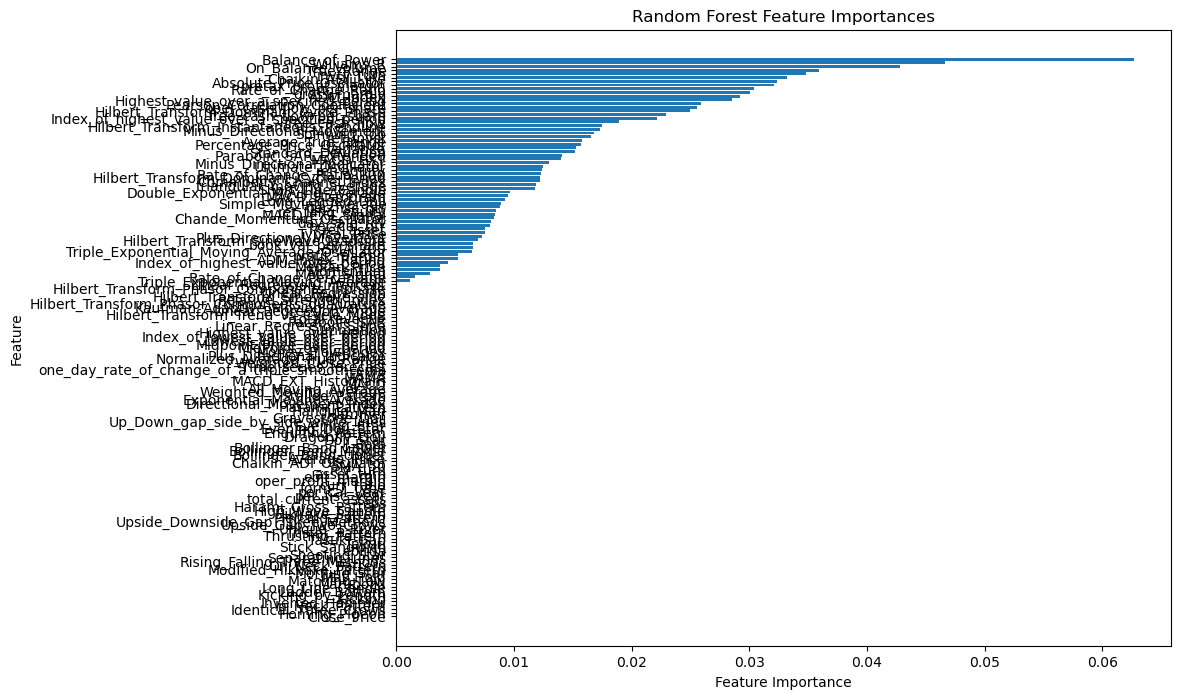

In [41]:
# Get feature importances from the model
importances_med = rf_med.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df_med = pd.DataFrame({
    'Feature': x_train_numeric_scaled_df.columns,
    'Importance': importances_med
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df_med)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df_med['Feature'], feature_importance_df_med['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [42]:
features_med = feature_importance_df_med[feature_importance_df_med['Importance'] > 0.01]
features_med.shape

(36, 2)

In [43]:
x_train_red_med = x_train_numeric_scaled_df[features_med['Feature']]
x_valid_red_med = x_valid_numeric_scaled_df[features_med['Feature']]
x_test_red_med = x_test_numeric_scaled_df[features_med['Feature']]
x_train_red_med.shape

(153, 36)

In [44]:
rf_med = RandomForestRegressor(random_state=2)
rf_med.fit(x_train_red_med, y_train_median)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red_med = rf_med.predict(x_valid_red_med)
mse_valid_red_med = mean_squared_error(y_valid_median, y_valid_pred_red_med)
print("Validation MSE:", mse_valid_red_med)

# predict and then compute R2 with r2_score:
r2_med = r2_score(y_valid_median, y_valid_pred_red_med)
print("R^2 score:", r2_med)

ss_res_med = np.sum((y_valid_median - y_valid_pred_red_med) ** 2)
ss_tot_med = np.sum((y_valid_median - np.mean(y_valid_median)) ** 2)

print("SS total:", ss_tot)
print("SS residual:", ss_res)

Validation MSE: 0.013915011058652761
R^2 score: -0.9387161114592699
SS total: 0.2537373841253839
SS residual: 0.4793285763518108


## Shapley Values